In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle


In [2]:
scripts_df=pd.read_csv("mystery_movie_data.csv")

## Introduction

Our project focuses on traditionally defined mystery movie villains and their relationships with other villains across time and different movies. We created a dataset that isolated mystery movies from other genres based on a criteria we came up with as a group: the movie must have an identifiable villain, a committed crime, and the idea that the villain has to be known in some other capacity before being confirmed as the villain. As a part of our data set, we conducted a sentiment analysis on each character's dialogue from each movie in our dataset. It measures how loaded a character’s dialogue is with each of the ten emotions (anger, anticipation, disgust, fear, joy, positive, negative, sadness, surprise, and trust) on a scale of 0 to 1. 


Our research questions were: does average villain sentiment change over time? As well as: do villains in the mystery movie genre more closely resemble other villains from across films or other characters in their own films? Our main findings for the first data analysis regarding villain sentiment over time include (TODO about Data Analysis 1). In our second data analysis regarding the inner versus intra textual similarity between villains, we ran three different significance tests to determine if there was a meaningful difference between villains’ similarities to other villains across movies and characters in their own movies. We found that villains are much more similar to other villains than average. Additionally, we drew borderline insignificant results about whether or not villains are more similar to other villains in different movies as opposed to other characters in their own movies, but that could be the result of stylistic differences between film scripts rather than structural ones between villains and other characters. However, it requires further research. Finally, we found that villains are significantly more similar to other characters in their movies than they are to villains from other movies.


## Data Description

For more information on our data preparation, description, and cleaning please view our appendix here (if you're viewing this locally then go to the appendix folder and both Jupyter notebooks can be found there): https://github.com/AsherML/info-2950/tree/main/appendix. 


## Data Analysis 1: Villain Sentiments Over Time

Our first branch of analysis takes a look at how the average villain sentiment, or attitude, changes over time. We're interested in how the portrayal of villains in movies across time reflects societal trends, specifically how villain sentiment changes reflect on social changes in real life. Our hypothesis is that villian sentiment becomes more violent and angry as time progress, largely based on the idea that what is socially appropriate for the media shifts as time progresses. 

First, we created linear regression models for each individual villain sentiment against the year the film was released. These regresssions will be used to find the coefficient of determination (r-square).

In [20]:
anger_fit = LinearRegression().fit(scripts_df[['mean_anger']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])

disgust_fit = LinearRegression().fit(scripts_df[['mean_disgust']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])

fear_fit = LinearRegression().fit(scripts_df[['mean_fear']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])

negative_fit = LinearRegression().fit(scripts_df[['mean_negative']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])



Now that we have created these linear regression models, we can find the coefficient of determination for each model. This will tell us the fit of each villain sentiment against time.

In [79]:
r_square = anger_fit.score(scripts_df[['mean_anger']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])
print('Villain Anger by Year Coefficient of Determination:', r_square)

Villain Anger by Year Coefficient of Determination: 0.05527364095554155


In [81]:
r_square = disgust_fit.score(scripts_df[['mean_disgust']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])
print('Villain Disgust by Year Coefficient of Determination:', r_square)

Villain Disgust by Year Coefficient of Determination: 2.894346643467216e-07


In [82]:
r_square = fear_fit.score(scripts_df[['mean_fear']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])
print('Villain Fear by Year Coefficient of Determination:', r_square)

Villain Fear by Year Coefficient of Determination: 0.05011145243753223


In [84]:
r_square = negative_fit.score(scripts_df[['mean_negative']][scripts_df['is_villain']],scripts_df[['year']][scripts_df['is_villain']])
print('Villain Negativity by Year Coefficient of Determination:', r_square)

Villain Negativity by Year Coefficient of Determination: 0.018849656451930152


Then, we created the variable "sentiments" which contains all character scores for characters labeled as villains. From there we created a linear regression model to determine the relationship between the sentiments and the year, not forgetting the villain status. Then, we found the coefficient of determination (R^2) statistic of our regression model which looks at sentiments by year. 

In [21]:
sentiments = scripts_df[['mean_anger', 'mean_anticipation', 'mean_disgust', 'mean_fear', 'mean_joy', 'mean_negative', 'mean_positive', 'mean_sadness', 'mean_surprise', 'mean_trust']][scripts_df['is_villain']]

every_sentiment_by_year = LinearRegression().fit(sentiments, scripts_df['year'][scripts_df['is_villain']])

every_sentiment_by_year.score(sentiments, scripts_df['year'][scripts_df['is_villain']])

0.3752561881194666

From the above scores, it looks like one sentiment has a high terribly correlation or predictive value in determing the year, but that when taking together they create a mild correlation). Next, we plotted each average villain sentiment against the variable year to see if there were any obvious trends at a first glance. We normalized the year the film was released by only looking at data from 1970 to modern day. 

Text(0.5, 1.0, 'Villain Anger Over Time')

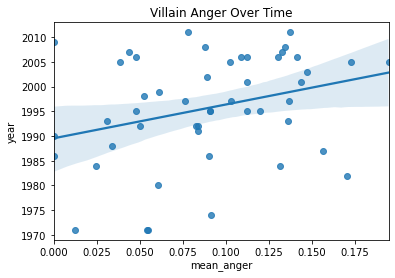

In [90]:
anger = sns.regplot(x = scripts_df['mean_anger'][scripts_df['is_villain']][scripts_df['year']>=1970], y = scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
anger.set_title('Villain Anger Over Time')

Text(0.5, 1.0, 'Villain Disgust Over Time')

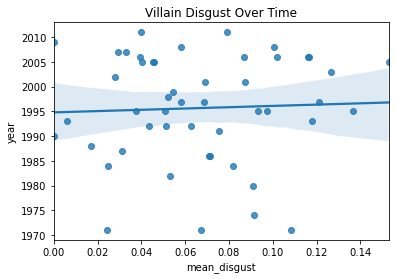

In [92]:
disgust = sns.regplot(x = scripts_df['mean_disgust'][scripts_df['is_villain']][scripts_df['year']>=1970], y = scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
disgust.set_title('Villain Disgust Over Time')

Text(0.5, 1.0, 'Villain Fear Over Time')

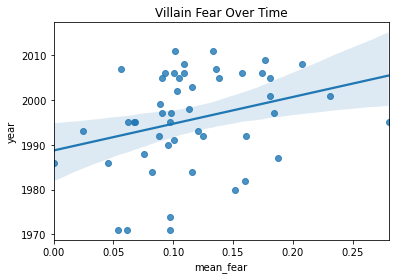

In [93]:
fear = sns.regplot(x = scripts_df['mean_fear'][scripts_df['is_villain']][scripts_df['year']>=1970], y = scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
fear.set_title('Villain Fear Over Time')

Text(0.5, 1.0, 'Villain Negativity Over Time')

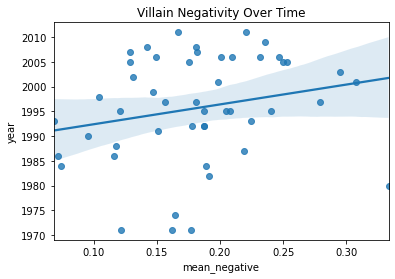

In [95]:
negative = sns.regplot(x = scripts_df['mean_negative'][scripts_df['is_villain']][scripts_df['year']>=1970], y = scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
negative.set_title('Villain Negativity Over Time')

## Significance of Villain Sentiments Over Time (Significance Testing 1)

While we're generally interested in the relationship between sentiments and time in mystery movies, more specifically we're focused on the relationship between violent sentiments and time. Has our media actually become more used to seeing gore and vulgarity on screen, or is this effect merely a popular media talking point. To answer this question, we isolated four key sentiments for our analysis: anger, disgust, fear, and negativity. We approached this task with the following hypothesis

    - H1: There will a strong positive correlation between a villain's expression of violent sentiments and the year their movie was released in

    - H0: There will be no correlation between a villain's expression of violent sentiments and the year their movie was released in

In [43]:
violent_sentiments=scripts_df['mean_anger'][scripts_df['is_villain']][scripts_df['year']>=1970]+scripts_df['mean_disgust'][scripts_df['is_villain']][scripts_df['year']>=1970]+scripts_df['mean_fear'][scripts_df['is_villain']][scripts_df['year']>=1970]+scripts_df['mean_negative'][scripts_df['is_villain']][scripts_df['year']>=1970]
violent_sentiments=[i/4 for i in violent_sentiments]

Text(0.5, 0, 'Mean violence Score')

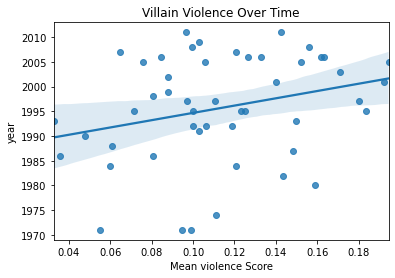

In [55]:
violence = sns.regplot(x = violent_sentiments, y = scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
violence.set_title('Villain Violence Over Time')
violence.set_xlabel("Mean violence Score")

Graphically, violence does not seem to be a particularily good predictor of the year in which a movie's released. This is further supported by the extremely low r^2 score calculated below

In [59]:
violence_columns = scripts_df[['mean_anger', 'mean_disgust', 'mean_fear',  'mean_negative']][scripts_df['is_villain']]
violence_year = LinearRegression().fit(violence_columns, scripts_df['year'][scripts_df['is_villain']])
score=violence_year.score(violence_columns, scripts_df['year'][scripts_df['is_villain']])
print("R^2 Coefficient of Determination between Violence and Year: {:.2f}".format(score))

R^2 Coefficient of Determination between Violence and Year: 0.09


However, before we reject the hypothesis in favor of the null we want to make sure these results didn't occur due to chance. We evaluate these results through a permutation test run below. Essentially, what we do is shuffle our violence sentiment scores and years randomly and then fit a linear regression on those randomized sets. This gives us a range of correlation coefficients we might expect to see if there truly was no relationship to be found. 

In [87]:
scores=[]
years=list(scripts_df['year'][scripts_df['is_villain']][scripts_df['year']>=1970])
for i in range(10000):
    permutated_x=random.sample(violent_sentiments, len(violent_sentiments))
    permutated_y=random.sample(years, len(years))
    permutated_fit=LinearRegression().fit(np.array(permutated_x).reshape(-1,1), permutated_y)
    scores.append(permutated_fit.score(np.array(permutated_x).reshape(-1,1), permutated_y))


Here's a quick function to help visualize confidence intervals that will be used both in this section and the next

In [89]:
def compare_with_confidence(baseline, comparors, labels, title):
    colors=['blue', 'green', 'red', 'purple', 'black', 'orange']
    labels.insert(0, "Confidence Interval")
    labels.insert(0, "Baseline")
    binsizes, _, _= plt.hist(baseline, bins=50)
    plt.vlines(np.quantile(baseline, 0.025), ymin=0, ymax=np.max(binsizes), color='green')
    plt.vlines(np.quantile(baseline, 0.975), ymin=0, ymax=np.max(binsizes), color='green')
    for i in range(len(comparors)):
        plt.vlines(comparors[i], ymin=0, ymax=np.max(binsizes), color=colors[i+2])
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Number of Occurances")
    legend_handles=[Rectangle((0,0), 1, 1, color=colors[c], ec='k') for c in range(len(labels))]
    plt.legend(legend_handles, labels, bbox_to_anchor=(1, 0, 0.45, 1))
    plt.title(title)
    plt.show()


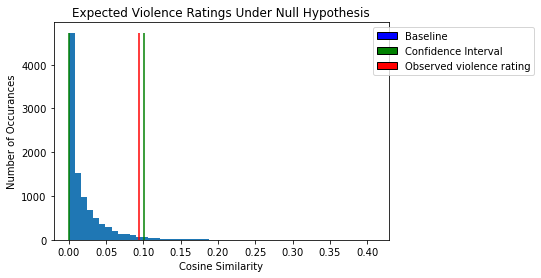

In [88]:
compare_with_confidence(scores, [score], ["Observed violence rating"], "Expected Violence Ratings Under Null Hypothesis")

Above, we see that we even if violence ratings and years were shuffled randomly, observing the correlation coefficient that we derived from our actually existing data is reasonable to expect given the balance of probability (p>0.05). As such, we must fail to reject the null hypothesis that the expression of violent sentiments in mystery movies has increased over time. 

## Data Analysis 2: Intra-archetype Distances vs Inter-archetype Distances and Similarities. 
 

Our second branch of analysis concerns how villains relate to other characters both within their own movies and from across the genre. Specifically, we're interested in how similar or different villains are as an archtype to other characters, and whether they are defined as villains more by the other characters in their movies or by something unique that transcends their own movie.

First, we created a matrix where each row represents a different character and each column represents the occurances of a specific word. Of note is the fact that we restrict our analysis to features (words) that occur in no less than 5 of the characters's scripts and no more than 90% of the characters's scripts (about 244 characters's scripts). We did this to reduce the influence of uninformative features, whether they occur too rarely to be of use or too often to help distinguish between characters. We also normalize by least squares to reduce the influence of extremely long scripts, and use idf weighting for the same purpose.

In [4]:
vectorizer=TfidfVectorizer(
    encoding='utf-8',
    min_df=5,
    max_df=0.9,
    binary=False,
    norm='l2',
    use_idf=True,
    strip_accents='unicode',
    lowercase=True
)
X_scripts=vectorizer.fit_transform(list(scripts_df['raw_dialogue']))

From here we use cosine similarity to measure how how similar each character is to any other. Cosine similarity is a measure which allows us to determine how far apart any two points are in a nth dimensional space by measuring the angle of the vector that connects them. This is useful because it doesn't care how many times each feature occurs in each charater's scripts, only the ratio of occurances between one script and another. This helps account for differences in overall document length (we would expect longer documents to use a word more often than shorter ones, everything else being equal) as well as differences in writing style between scripts. This makes it a better fit than something like euclidean distance or city-block distance measures. 

In [16]:
#get cosine similarities between each character, both in terms of the words in their scripts and their embeddings (cos and cos_embeddings respectively)
cos=cosine_similarity(X_scripts)
embeddings=np.rot90([scripts_df['embedding_'+str(i)] for i in range(300)])[::-1]
cos_embeddings=cosine_similarity(embeddings)

Our study then divides characters into one of two types: villains and "others". This isn't to say that there aren't other categories, merely that we're focusing exclusively on how villains relate to other character types. As such we identify three inter-textual (across movies) relationships: villain-villain, villain-other, and other-other. The next bit of code finds the similarities between all characters and groups them by relationship type

In [6]:
# get the positiions of all villains and other characters in the similaritiy matrix
villains_indices=[i for i in range(len(scripts_df)) if scripts_df['is_villain'][i]]
other_indices=[i for i in range(len(scripts_df)) if not(scripts_df['is_villain'][i])]

# set up empty arrays for each of the three types of relationships (villain-villain, villain-other, and other-other) for both word and embeddings
all_villain_villain_similarities=[]
all_other_other_similarities=[]
all_villain_other_similarities=[]
embedding_villain_villain_similarities=[]
embedding_other_other_similarities=[]
embedding_villain_other_similarities=[]

# for each character in the matrix, get their similarities to all other characters and add those similarities to the correct array
for i in range(len(scripts_df)):
    if i in villains_indices:
        for x in range(i+1, len(scripts_df)):
            if x in villains_indices:
                all_villain_villain_similarities.append(cos[i][x])
                embedding_villain_villain_similarities.append(cos_embeddings[i][x])
            elif x in other_indices:
                all_villain_other_similarities.append(cos[i][x])
                embedding_villain_other_similarities.append(cos_embeddings[i][x])
    elif i in other_indices:
        for x in range(i+1, len(scripts_df)):
            if x in other_indices:
                all_other_other_similarities.append(cos[i][x])
                embedding_other_other_similarities.append(cos_embeddings[i][x])

Next we assess inner-textual relationships, how characters relate to other characters in their movies. The next few sections of code gets the similarity both of all characters within their own movies and specifically the villains to other characters in their movies.  

In [7]:
# get the locations in the similaritiy matrix of each movie
movie_ranges=[]

reverse_titles=scripts_df['movie_title'][::-1]

for i in set(scripts_df['movie_title']):
    first_instance=list(scripts_df['movie_title']).index(i)
    last_instance=len(reverse_titles)-1-list(reverse_titles).index(i)
    movie_ranges.append([first_instance, last_instance+1])
movie_ranges.sort()

In [8]:
# collect the similarity of villains to all characters in their movie (villain_movie_similarities and villain_movie_embedding_similarities) and for all characters in a given movie (movie_similarities and movie_embedding_similarities)

movie_similarities=[]
movie_embedding_similarities=[]
for movie in movie_ranges:
    similarities=[]
    embedding_similarities=[]
    for i in range(movie[0], movie[1]):
        for x in range(i, movie[1]):
            if x!=i:
                similarities.append(cos[i][x])
                embedding_similarities.append(cos_embeddings[i][x])
    movie_similarities.append(similarities)
    movie_embedding_similarities.append(embedding_similarities)

villain_movie_similarities=[]
villain_movie_embedding_similarities=[]
for movie in movie_ranges:
    similarities=[]
    embedding_similarities=[]
    for i in range(movie[0], movie[1]):
        if bool(scripts_df.iloc[i]['is_villain']):
            for x in range(movie[0], movie[1]):
                if x!=i:
                    similarities.append(cos[x][i])
                    embedding_similarities.append(cos_embeddings[x][i])
    villain_movie_similarities.append(similarities)
    villain_movie_embedding_similarities.append(embedding_similarities)

movie_similarities=[np.mean(i) for i in movie_similarities if i!=[]]
movie_embedding_similarities=[np.mean(i) for i in movie_embedding_similarities if i!=[]]

villain_movie_similarities=[np.mean(i) for i in villain_movie_similarities if i!=[]]
villain_movie_embedding_similarities=[np.mean(i) for i in villain_movie_embedding_similarities if i!=[]]

Here we get the average similarities for all five groupings

In [9]:
# get the means of all similarities of each type, both for regular and embedded and assign them to variables
intra_villain_similarities=np.mean(villain_movie_similarities)
intra_villain_embedding_similarities=np.mean(villain_movie_embedding_similarities)

intra_movie_similarities=np.mean(movie_similarities)
intra_movie_embedding_similarities=np.mean(movie_embedding_similarities)

inter_other_other=np.mean(all_other_other_similarities)
inter_other_other_embedding=np.mean(embedding_other_other_similarities)

inter_villain_other=np.mean(all_villain_other_similarities)
inter_villain_other_embedding=np.mean(embedding_villain_other_similarities)

inter_villain_villain=np.mean(all_villain_villain_similarities)
inter_villain_villain_embedding=np.mean(embedding_villain_villain_similarities)

inter_all_characters=np.mean(cos)
inter_all_embeddings=np.mean(cos_embeddings)


Next we display our findings. Below we show how similar characters are on average for each of the three key inter-textual relationships (villain-villain, villain-other, and other-other), as well as how similar characters are generally regardless of relationship. We show this for both individual tokenized measures and embeddings

In [11]:
inter_token_df=pd.DataFrame({"Villain": [inter_villain_other, inter_villain_villain, np.nan], "Other": [inter_other_other, inter_villain_other, np.nan], "All": [np.nan, np.nan, inter_all_characters], "character_type (token)": ['Other', 'Villain', "All"]})
inter_token_df.set_index("character_type (token)")

,Villain,Other,All
character_type (token),,,
Other,0.220046,0.202193,NaN
Villain,0.244409,0.220046,NaN
All,NaN,NaN,0.212743


In [12]:
inter_embedding_df=pd.DataFrame({"Villain": [inter_villain_other_embedding, inter_villain_villain_embedding, np.nan], "Other": [inter_other_other_embedding, inter_villain_other_embedding, np.nan], "All": [np.nan, np.nan, inter_all_embeddings], "character_type (embedding)": ['Other', 'Villain', "All"]})
inter_embedding_df.set_index("character_type (embedding)")

,Villain,Other,All
character_type (embedding),,,
Other,0.909875,0.900949,NaN
Villain,0.911772,0.909875,NaN
All,NaN,NaN,0.903325


We also show intra-textual relationships below, both in terms of all characters in a movie and specifically villains to their movie counterparts

In [13]:
intra_df=pd.DataFrame({"Whole-Movie": [intra_movie_similarities, intra_movie_embedding_similarities], "Villain-Movie": [intra_villain_similarities, intra_villain_embedding_similarities], "Metric": ["Token", "Embedding"]}).set_index("Metric")
intra_df.head()

,Whole-Movie,Villain-Movie
Metric,,
Token,0.367985,0.377853
Embedding,0.934572,0.939277


## Significance of Inner vs Intra Textual Similarity

In order to see whether our results actually capture a meaningful difference in similariies across character types, we used a bootstrapping paradigm with 5000 iterations to construct confidence intervals around our base set of similarities. In other words, by resampling with replacement, we can see with 95% certainty where the true mean similarity between different characters should be if all characters or all characters in a certain type had an equal likeliehood of being similar. If the mean similarity of any of our actually studied relationships falls outside this range, we can be reasonably certain that we did not observe it due to chance and that the measurement is significant. 

A quick note on implementation. Our similarity matrix represents the similarity of the character labeled on the y axis to the character on the x. This means that the similarity between characters 3 and 4, for example, is equivalent to the similarity between 4 and 3. As such, our similarity matrix is essentially mirrored across the y=-x axis, with every element on the diagonal being equal to one (every character is perfectly similar to itself). To combat this redundancy and avoid artificially inflating our similarity scores, we constructed our confidence intervals using a subset of the similarity matrix consisting of the lower triangle below the diagonal. 

In [17]:
%%time
"""
associated arrays:
movie_similarities, movie_embedding_similarities

villain_movie_similarities, villain_movie_embedding_similarities


all_villain_villain_similarities=[]
all_other_other_similarities=[]
all_villain_other_similarities=[]
embedding_villain_villain_similarities=[]
embedding_other_other_similarities=[]
embedding_villain_other_similarities=[]

"""

test_movie_means=[]
test_movie_embedding_means=[]
test_inner_villain_means=[]
test_inner_villain_embedding_means=[]
test_other_other_means=[]
test_other_other_embedding_means=[]
test_villain_villain_means=[]
test_villain_villain_embedding_means=[]
test_villain_other_means=[]
test_villain_other_embedding_means=[]
test_all_means=[]
test_all_embedding_means=[]

lower_indices=np.tril_indices(271, k=-1)

cos_lower=cos[lower_indices]
cos_embedding_lower=cos_embeddings[lower_indices]

for i in range(5000):
    test_movie_means.append(np.mean(random.choices(movie_similarities, k=len(movie_similarities))))
    test_movie_embedding_means.append(np.mean(random.choices(movie_embedding_similarities,k=len(movie_embedding_similarities))))

    test_inner_villain_means.append(np.mean(random.choices(villain_movie_similarities, k=len(villain_movie_similarities))))
    test_inner_villain_embedding_means.append(np.mean(random.choices(villain_movie_embedding_similarities, k=len(villain_movie_embedding_similarities))))

    test_other_other_means.append(np.mean(random.choices(all_other_other_similarities, k=len(all_other_other_similarities))))
    test_other_other_embedding_means.append(np.mean(random.choices(embedding_other_other_similarities, k=len(embedding_other_other_similarities))))

    test_villain_villain_means.append(np.mean(random.choices(all_villain_villain_similarities, k=len(all_villain_villain_similarities))))
    test_villain_villain_embedding_means.append(np.mean(random.choices(embedding_villain_villain_similarities, k=len(embedding_villain_villain_similarities))))

    test_villain_other_means.append(np.mean(random.choices(all_villain_other_similarities, k=len(all_villain_other_similarities))))
    test_villain_other_embedding_means.append(np.mean(random.choices(embedding_villain_other_similarities, k=len(embedding_villain_other_similarities))))

    test_all_means.append(np.mean(random.choices(cos_lower, k=len(cos_lower))))
    test_all_embedding_means.append(np.mean(random.choices(cos_embedding_lower, k=len(cos_embedding_lower))))



Wall time: 17min 5s


### Test 1: Are Villains More Similar to Other Villains Than Average

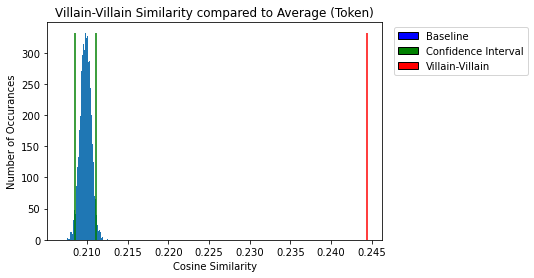

In [19]:
compare_with_confidence(test_all_means, [inter_villain_villain], ['Villain-Villain'], "Villain-Villain Similarity compared to Average (Token)")

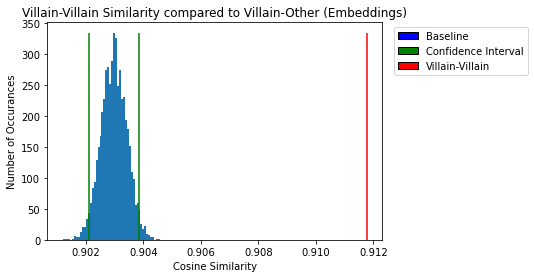

In [16]:
compare_with_confidence(test_all_embedding_means, [inter_villain_villain_embedding], ['Villain-Villain'], "Villain-Villain Similarity compared to Average (Embeddings)")

The above results describe how similar two villains are across texts on average compared to how similar we would expect any two characters to be. The top graph shows this measurement based on the actual words each character says, whereas the bottom shows the same measurement but with character embeddings (described above) instead of words. This format will be used for all subsequent tests for this section. 

The results are remarkable. In both cases, villains are much more similar to other villains than we would expect to see if there were no meaningful differences between villains and other characters across texts. Below is shown just how many standard deviations above the mean similarity score villain-villain relationships were: 

In [18]:
print("Number of standard deviations above average similarity (token): {:.2f}".format((inter_villain_villain - np.mean(test_all_means))/np.std(test_all_means)))

print("Number of standard deviations above the mean (embedding): {:.2f}".format((inter_villain_villain_embedding - np.mean(test_all_embedding_means))/np.std(test_all_embedding_means)))

Number of standard deviations above average similarity (token): 52.90
Number of standard deviations above the mean (embedding): 19.62


Above we see that the degree to which villains are more similar to other villains than other characters are on average is so high it's extremely unlikely to have occurred due to chance (p<0.01). 

### Test 2: Are Villains More Similar to Other Villains Than they are to Other Characters

This next test is slightly different from the one above. Above, we established that villains are fundamentally more similar than any two characters are on average. Here, we investigate whether villains are more similar to other villains than those same villains are to other characters. Another way to think about this is that instead of comparing villain-villain relationships to all three relationships combined (villain-villain + villain-other + other-other) we are specifically here looking at villain-villain vs villain-other relationships. 

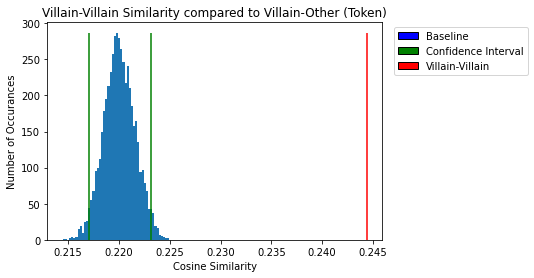

In [19]:
compare_with_confidence(test_villain_other_means, [inter_villain_villain], ['Villain-Villain'], "Villain-Villain Similarity compared to Villain-Other (Token)")

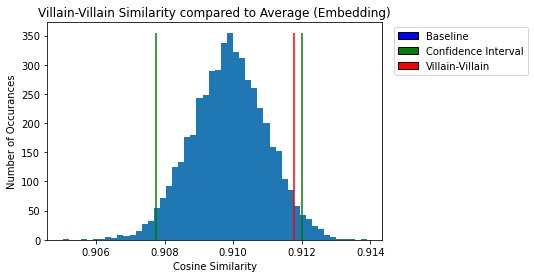

In [20]:
compare_with_confidence(test_villain_other_embedding_means, [inter_villain_villain_embedding], ['Villain-Villain'], "Villain-Villain Similarity compared to Average (Embedding)")

The above results are slightly less clear. On the one hand, when looked at in terms of the actual words spoken the similarity between villains seems strikingly higher between villains and other character types. However, when looked at in terms of character embeddings, the difference in similarities between villain-villain similarities and villain-other similarities seems to fall within what we might expect due to random chance (albeit it at the high end). The extremities are shown in more detail below:

In [32]:
print("Number of standard deviations above villain-other (token): {:.2f}".format((inter_villain_villain - np.mean(test_villain_other_means))/np.std(test_villain_other_means)))

print("Number of standard deviations above the mean (embedding): {:.2f}".format((inter_villain_villain_embedding - np.mean(test_villain_other_embedding_means))/np.std(test_villain_other_embedding_means)))

Number of standard deviations above villain-other (token): 15.79
Number of standard deviations above the mean (embedding): 1.73


The implications of this are ambiguous. After all, both tokenized and embedded measures represent the same characters with the same dialogues, it's not like similarity can be statistically significant for one but not the other. One possible explanation could be that the majority of difference between villains and other characters is style based rather than content based. Embeddings help to simplify text analysis by condensing words with similar meanings into shared regions of dimensional space. While a token-based measurement would view words with similar meanings as distinct, the embedded model would represent those words similarily. If most of the difference between villains and other characters relied upon such distinctions between words with similar meanings but different connotations or stylistic considerations, then the token based model would rank such relationships as wildly different while the embedded model might view them as more similar. Another possible example is that writers choose to create tension in the story by taking bits of other characters personalities and including them in the villain. This might help to ratchet up the suspense: by making the villain as similar to other characters as possible, the writer might make it harder for the audience to determine who is in fact the perpetrator before the ending of the movie. This would cause the two character types to have a high shared degree of similarity by embeddings, even if different exact words are chosen. However, more study is needed before either of these two hypothesis can be confirmed, or any meaningful difference can indeed be stated for certain. 

### Test 3: Are Villains More Similar to Other Characters in their Movies than Villains Across Texts

Here we investigate which type of relationship is most important: character type or movie. What we want to determine is whether villains are defined by the other characters in their movies or whether there are archetypal traits that are unique to all villains. We test this by measuring the similarity of villains to other characters in their movies as opposed to the similarity of villains to all other villains.

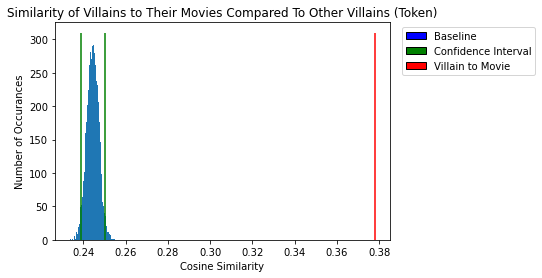

In [603]:
compare_with_confidence(test_villain_villain_means, [intra_villain_similarities], ["Villain to Movie"], "Similarity of Villains to Their Movies Compared To Other Villains (Token)")

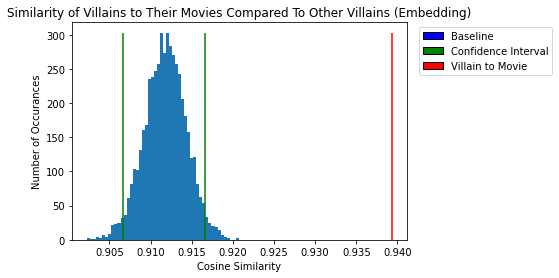

In [604]:
compare_with_confidence(test_villain_villain_embedding_means, [intra_villain_embedding_similarities], ["Villain to Movie"], "Similarity of Villains to Their Movies Compared To Other Villains (Embedding)")

Above the results are pretty clear. Whether one considers the token based measurements or the embedding based ones, villains are significantly more similar to other characters in their movies than they are to villains from other movies. Just how significantly is shown below in terms of standard deviations above the mean

In [610]:
print("Number of standard deviations above the mean (token): {:.2f}".format((intra_villain_similarities - np.mean(test_villain_villain_means))/np.std(test_villain_villain_means)))

print("Number of standard deviations above the mean (embedding): {:.2f}".format((intra_villain_embedding_similarities - np.mean(test_villain_villain_embedding_means))/np.std(test_villain_villain_embedding_means)))

Number of standard deviations above the mean (token): 47.12
Number of standard deviations above the mean (embedding): 10.79


The lower extremity of the embedding's based measurement maskes sense considering the concentration of embeddings towards the upper end of the scale. However, in both cases the chances that villains are not more similar to other characters in their movies than to other villains across movies is vanishingly small (p<0.01). This supports our initial hypothesis that villains are at least in part defined by other characters in their movies, rather than possessing innate "evil" qualities which make them a villain.

## Interpretations and Limitations

Our data set was a compilation of hand-selected movies that fit the archetypal mystery movie stereotype, with a villain to be found. We ended up with approximately 50 scripts to pull from, which means that the patterns we are seeing in villains only are based off of these 50 movies over time. This could be a representation concern if we were to be using this data to be representative of all films, but given that we are only discussing that one subset of mystery movies, this limiting aspect of our data should also be okay. The results we get could be vaguely generalizing for people who watch this particular sub genre of film, but if they are wary of our sample size then hopefully it should be alright. Something to consider here in the big picture is that our data could fail to represent all villains if people misinterpret what we are analyzing. We know that we are picking the archetypal mystery film to study, but not all viewers may realize that, which could lead to a construed view of our research. 

We are not analyzing the villains speech pattern off of every character in the movie, but off of five main characters who are not villains. By normalizing the data of these spoken characters across films we will be eliminating most of the room for error, but if a movie did need more than five characters to be represented of the story line than that could be a limitation on the part of our data. Again, this has similar limitations if our data set is flawed, it could lead to a false image in regards to our results. 


The data collected also is very variable depending on the film, in some films, the five main characters have a consistent number of lines and amount of interactions, but for others that is not the case. This skew could make it seem as though villains have a similar tone to regular characters in one movie, when in reality, the characters all have similar tones because they all live in the same town and have experienced similar things. While we normalized the words in the script for the characters in an attempt to equalize the movies, the tone remains unaccounted for and largely impossible to account for. While this should not really cause problems after we cleaned the data, once again the limitation has the potential to be impactful if people apply our results to more general movies. 

## Conclusion

Overall, our work showed a lot of interesting patterns and happenings in regards to villians in these particular movies. While discussed in greater depth above, a quick synopsis can be read here. 


Portrayals in media often tend to reflect that of society over time. When violence occurs more often and more casually, one would assume that same casual violence may emerge in the media. This same trend can be considered regardless of the content and was what we decided to look at when we considered villain sentiment overtime. The trend of movie villain sentiment over time did something.  

Although we did not see any trends proving this, this stagnation regarding villain behavior changes over time points to an interesting flaw in societal beliefs. The “Back in my Day” everchanging view of the older generation when referencing alleged changes may not hold up against villain portrayal in films. As these types of characters remain relatively constant overtime, and the world seems to shift into more violence, it is nice to know that some things are not changing for the worse, and villains, while they are bad, are no more bad sentiment wise than they were before. The portrayal of people in the media remains interesting, especially when considering that villain sentiment analysis could be reflective of social changes in real life.

**Data Analysis 2**


For the second analysis we focused on how villains relate stereotypically to other characters both within their own movies and from across the mystery genre. In particular, this focus was meant to test if villains were as archetypally portrayed as anticipated and if it is their own behavior or others that makes them the villain. 

This led us to test for a few hypotheses. Our first test proved remarkably that villians are on average more similar to other villains across movies. The second test was less clear. It did not prove that villians were significantly different from other types of characters across films and to truly determine if that were the case would require more research. Finally, the third test solidified our hypothesis that villians are defined as such due to the nature of other characters in the film.

Characters such as villains are often thought to be defined by the characters surrounding them, which is why our tests proved so crucial. Although we often think of villains and heroes or villains and other characters as fundamentally opposed and different, it is not clear if one impacts the other. Are villains innately “villian-ish,” or do they only appear that way due to the existence of other normal characters? Whether or not these differences define the nature of characters was our main interest in this second portion of our research. The analysis ended up proving that villains are in fact shaped by those around them. This last point is useful both from a fictional-analysis standpoint and to potentially isolate issues of bias in character portrayals. 


Appendix: 

- https://github.com/AsherML/info-2950/tree/main/appendix/data_preparation.ipynb
- https://github.com/AsherML/info-2950/tree/main/appendix/data_description.ipynb 

## Questions For Reviewers

- Is our introduction clear enough to understand the scope of our project and our methods for our analyses? 
- Is there anything that you would change about the methods we used for our two analyses?
- Are there any obvious interpretations or limitations that we might have missed when conducting our research?
- Is there anything in our project that you feel could be improved upon, generally speaking? 
